In [1]:
# !pip install mlflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import os
import time
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV


import mlflow
import mlflow.statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.4f}".format)

# Load the Data

In [3]:
cameraAcc_final = pd.read_csv("Modelling_Data/cameraAcc_final.csv")
gamingAcc_final = pd.read_csv("Modelling_Data/gamingAcc_final.csv")
homeAudio_final = pd.read_csv("Modelling_Data/homeAudio_final.csv")

# Modelling

## 1. Camera Accessory - Basic Additive Linear Model

In [4]:
# calculate the elasticity of the important KPIs
def getElasticity(train, gmv, coefficient):
    elasticity = []
    for i in coefficient.feature:
        feature_mean = train[i].mean()
        elasticity.append((((coefficient.loc[coefficient['feature']==i]['coefficient'].mean())*feature_mean)/gmv.mean()))
    coefficient['elasticity'] = pd.Series(elasticity)
    return coefficient

- Elasticity > 1: The feature has a strong positive impact on sales.
- Elasticity between 0 and 1: The feature has a small but positive impact.
- Elasticity < 0: The feature negatively affects sales (e.g., excessive discounts reducing profitability).

In [5]:
# dropping unnecessary columns which are under no control of the company
cameraAcc_model = cameraAcc_final.drop(['selling_price','units','product_mrp','total_transactions'], axis = 1)

In [6]:
cameraAcc_model.shape

(52, 46)

In [7]:
# Splitting the Dataset into Train and Test
df_train, df_test = train_test_split(cameraAcc_model, train_size=0.8, test_size=0.2, random_state=100)

In [8]:
# Assigning the X_train, X_test, y_train & y_test values
y_train = df_train.pop('gmv')
X_train = df_train

y_test = df_test.pop('gmv')
X_test = df_test

In [9]:
cameraAcc_final.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'units', 'sla',
       'product_procurement_sla', 'product_mrp', 'selling_price', 'NPS',
       'discount', 'total_transactions', 'total_premium_products',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'Binoculars',
       'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter',
       'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [10]:
# Scaling all the numerical values

num_cols = [
    'adStock_TV', 'adStock_Digital', 'adStock_Sponsorship', 'adStock_Content Marketing',
    'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio',
    'adStock_Other', 'sla', 'product_procurement_sla', 'discount', 'NPS', 
    'total_holidays', 'total_special_sale_days', 'total_pay_days', 
    'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery', 
    'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup', 
    'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount', 
    'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 
    'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope'
]

def scale_features(scaler, train_df, test_df, columns):
    """ Scales numerical features using the provided scaler. """
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()
    
    # Fit the scaler on training data & transform both train and test sets
    train_scaled[columns] = scaler.fit_transform(train_df[columns])
    test_scaled[columns] = scaler.transform(test_df[columns])
    
    return train_scaled, test_scaled


scaler = MinMaxScaler()
X_train_scaled, X_test_scaled = scale_features(scaler, X_train, X_test, num_cols)

In [11]:
# Applying RFE for Features Selection

def select_top_features(X_train, y_train, model, n_features=20):
    """
    Perform Recursive Feature Elimination (RFE) to select top features.
    
    Args:
        X_train (pd.DataFrame): Feature matrix for training.
        y_train (pd.Series): Target variable.
        model: Regression model (e.g., LinearRegression).
        n_features (int): Number of features to select.
    
    Returns:
        list: Selected top feature names.
    """
    # Initialize RFE with the model and specify number of features to select
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    
    # Fit RFE on the training data
    rfe.fit(X_train, y_train)

    # Return the selected feature names
    return X_train.columns[rfe.support_].tolist()

# Initialize Linear Regression model
lm = LinearRegression()

# Execute RFE and get the top 20 features
top_features = select_top_features(X_train, y_train, lm, n_features=30)

# Display selected features
print("Top 20 Features Selected by RFE:")
print(top_features)

Top 20 Features Selected by RFE:
['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital', 'adStock_Sponsorship', 'adStock_Content Marketing', 'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla', 'discount', 'is_holiday', 'total_special_sale_days', 'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount', 'ExtensionTube', 'FlashShoeAdapter', 'ReflectorUmbrella', 'Softbox', 'Telescope']


In [12]:
# Creating X_train_rfe dataframe with RFE selected features
X_train_rfe = X_train[top_features]

In [13]:
def calculate_vif(X):
    """
    Computes the Variance Inflation Factor (VIF) for each feature in the dataset.
    
    Args:
        X (pd.DataFrame): Feature matrix.
    
    Returns:
        pd.DataFrame: DataFrame containing features and their respective VIF scores.
    """
    X = X.copy()  # Ensure we don't modify the original dataset
    X = sm.add_constant(X)  # Add intercept for proper VIF calculation

    vif_data = pd.DataFrame()
    vif_data["Features"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data.sort_values(by="VIF", ascending=False)

# Compute VIF for RFE-selected features
vif_rfe = calculate_vif(X_train_rfe)

# Print VIF before regression
print("\nVIF Before Running Regression:")
print(vif_rfe)


VIF Before Running Regression:
                     Features              VIF
20                 is_pay_day              inf
19             total_pay_days              inf
0                       const 22823664057.7458
10                adStock_SEM      118502.4768
5             adStock_Digital       72171.0893
11              adStock_Radio       62876.0795
12              adStock_Other       57228.0174
4                  adStock_TV        4602.3519
9         adStock_ Affiliates        3970.5962
8    adStock_Online marketing        3153.3911
7   adStock_Content Marketing        2395.0992
3                        Year        1384.5406
2                       Month         977.6546
1                  order_week         497.4108
6         adStock_Sponsorship         179.2504
25                CameraMount          25.4234
30                  Telescope          24.5389
22            CameraFilmRolls          24.1346
17    total_special_sale_days          21.2319
18        is_special_sale_da

In [14]:
# dropping some columns with high VIF
X_train_rfe = X_train_rfe.drop(columns = ['Year', 'Month', 'order_week', 'total_special_sale_days', 'total_pay_days', 'is_pay_day', 
                                         'adStock_SEM'])

vif_rfe = calculate_vif(X_train_rfe)
print(vif_rfe)

                     Features       VIF
0                       const 4051.2744
5    adStock_Online marketing 1083.2900
6         adStock_ Affiliates 1025.8382
4   adStock_Content Marketing  379.9947
8               adStock_Other  226.2978
7               adStock_Radio  192.4857
2             adStock_Digital  177.2255
3         adStock_Sponsorship   79.4268
1                  adStock_TV   61.4933
18                CameraMount   16.3374
23                  Telescope   16.1066
17           CameraMicrophone   13.3796
15            CameraFilmRolls   10.8804
10    product_procurement_sla    8.9057
11                   discount    6.9361
16              CameraHousing    6.7364
21          ReflectorUmbrella    5.6428
19              ExtensionTube    5.5555
9                         sla    5.2513
22                    Softbox    4.5058
14               CameraEyeCup    3.7614
12                 is_holiday    3.3443
13        is_special_sale_day    1.9433
20           FlashShoeAdapter    1.6377


In [15]:
# Create a folder for storing models if it doesn’t exist
os.makedirs("Models", exist_ok=True)

# Initialize model count globally (to dynamically name runs if no name is provided)
model_count = 0

def run_ols_experiment(X_train, y_train, run_name=None):
    """
    Runs an OLS regression model, tracks it in MLflow, and saves results in 'Models' folder.
    
    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Target variable.
        run_name (str, optional): Custom name for the MLflow run. Defaults to "model_run_X".
    
    Returns:
        str: The name of the model saved.
    """
    global model_count
    model_count += 1  # Increment model count for unique naming if no run name is provided

    # If no custom run name is given, generate a default one
    if run_name is None:
        run_name = f"model_run_{model_count}"

    # Paths for saving artifacts
    vif_filename = f"Models/vif_scores_{run_name}.csv"
    summary_filename = f"Models/ols_summary_{run_name}.txt"
    model_path = f"Models/{run_name}"

    # Start MLflow Experiment
    mlflow.set_experiment("Marketing Mix Model")

    with mlflow.start_run(run_name=run_name):
        print(f"Training and tracking {run_name}...")

        # Adding a constant for OLS
        X_train_lm = sm.add_constant(X_train)

        # Train OLS Model
        lr = sm.OLS(y_train, X_train_lm).fit()
        
        # Print the model summary
        print(lr.summary())

        # Calculate VIF for feature selection
        vif = pd.DataFrame()
        vif['Features'] = X_train_lm.columns
        vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
        vif['VIF'] = round(vif['VIF'], 2)
        vif = vif.sort_values(by="VIF", ascending=False)

        # **Ensure VIF gets printed**
        print("\nVariance Inflation Factor (VIF):")
        print(vif)

        # Log Model Parameters (Selected Features)
        mlflow.log_param("num_features", len(X_train.columns))
        mlflow.log_param("features", list(X_train.columns))

        # Log Metrics (R-squared, AIC, BIC)
        mlflow.log_metric("r2_score", lr.rsquared)
        mlflow.log_metric("adj_r2_score", lr.rsquared_adj)
        mlflow.log_metric("AIC", lr.aic)
        mlflow.log_metric("BIC", lr.bic)

        # Save VIF DataFrame as an artifact
        vif.to_csv(vif_filename, index=False)
        mlflow.log_artifact(vif_filename)

        # Save Model Summary as an artifact
        with open(summary_filename, "w") as f:
            f.write(lr.summary().as_text())
        mlflow.log_artifact(summary_filename)

        # Log the trained model in MLflow with an input example
        mlflow.statsmodels.log_model(lr, run_name, input_example=X_train_lm.iloc[:1])

        print(f"{run_name} tracked in MLflow successfully! ✅")

    return run_name, lr  # Return the name of the saved model


In [16]:
# Running First Model
run_ols_experiment(X_train_rfe, y_train, run_name="MMM_OLS_Add_Model_1")

Training and tracking MMM_OLS_Add_Model_1...
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     7.058
Date:                Sat, 08 Mar 2025   Prob (F-statistic):           6.82e-05
Time:                        00:45:31   Log-Likelihood:                -576.70
No. Observations:                  41   AIC:                             1201.
Df Residuals:                      17   BIC:                             1243.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

('MMM_OLS_Add_Model_1',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x25183577c40>)

### Estimate Best Method Using Backward Elimination (removing features with high p-values, vif>10)

In [17]:
def backward_elimination(X_train, y_train, p_value_threshold=0.10, max_runs=None):
    """
    Performs automated backward elimination by removing features with high p-values.
    
    Args:
        X_train (pd.DataFrame): Feature matrix.
        y_train (pd.Series): Target variable.
        p_value_threshold (float): Maximum allowed p-value.
        max_runs (int, optional): Maximum number of times the model should run before stopping.

    Returns:
        X_train_selected (pd.DataFrame): Optimized feature matrix after elimination.
        final_model (statsmodels regression model): Trained regression model.
        execution_time (float): Time taken for the backward elimination process.
    """
    start_time = time.time()  # Start the timer
    run_count = 0  # Track the number of runs

    X_train = X_train.copy()  # Make a copy to avoid modifying the original data
    X_train = sm.add_constant(X_train)  # Add intercept (constant term)
    
    while True:
        run_count += 1
        # Fit OLS regression model
        model = sm.OLS(y_train, X_train).fit()

        # Get p-values and identify the max p-value
        p_values = model.pvalues[1:]  # Exclude the constant term
        max_p_value = p_values.max()

        # Step 1: Remove the feature with the highest p-value above the threshold
        if max_p_value > p_value_threshold:
            feature_to_remove = p_values.idxmax()
            print(f"Run {run_count}: Removing {feature_to_remove} (p-value: {max_p_value:.4f})")
            X_train.drop(columns=[feature_to_remove], inplace=True)
            
            # Stop if max_runs limit is reached
            if max_runs is not None and run_count >= max_runs:
                print(f"\n⏹️ Stopping early after {max_runs} runs as per max_runs limit.")
                break
            
            continue  # Restart loop after removing the feature

        # Stop if no feature meets removal criteria
        break

    # End the timer
    end_time = time.time()
    execution_time = end_time - start_time  # Calculate execution time

    print("\nFinal model summary:")
    print(model.summary())

    print(f"\n⏳ Backward Elimination Process Completed in {execution_time:.2f} seconds ⏳")

    return X_train, model, execution_time  # Return execution time as well

In [18]:
# Backward Elimination using P-value
X_train_selected, final_model, exec_time = backward_elimination(X_train_rfe, y_train, max_runs=17)

Run 1: Removing CameraHousing (p-value: 0.9653)
Run 2: Removing is_holiday (p-value: 0.9414)
Run 3: Removing CameraMount (p-value: 0.9439)
Run 4: Removing ExtensionTube (p-value: 0.7794)
Run 5: Removing CameraEyeCup (p-value: 0.7414)
Run 6: Removing CameraMicrophone (p-value: 0.6044)
Run 7: Removing CameraFilmRolls (p-value: 0.6768)
Run 8: Removing adStock_Content Marketing (p-value: 0.6566)
Run 9: Removing FlashShoeAdapter (p-value: 0.4959)
Run 10: Removing adStock_Online marketing (p-value: 0.4468)
Run 11: Removing ReflectorUmbrella (p-value: 0.4030)
Run 12: Removing is_special_sale_day (p-value: 0.2496)
Run 13: Removing adStock_ Affiliates (p-value: 0.3876)
Run 14: Removing adStock_Radio (p-value: 0.2980)
Run 15: Removing adStock_Other (p-value: 0.4691)
Run 16: Removing Softbox (p-value: 0.2790)

Final model summary:
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.876
Model:    

In [19]:
# import time  # Import time module
# import statsmodels.api as sm
# import pandas as pd

# def backward_elimination_aic(X_train, y_train, p_value_threshold=0.10, max_runs=None):
#     """
#     Performs automated backward elimination by removing features with high p-values
#     and selects the best model based on the lowest AIC value.

#     Args:
#         X_train (pd.DataFrame): Feature matrix.
#         y_train (pd.Series): Target variable.
#         p_value_threshold (float): Maximum allowed p-value.
#         max_runs (int, optional): Maximum number of iterations allowed.

#     Returns:
#         X_train_best (pd.DataFrame): Optimized feature matrix with the best AIC.
#         best_model (statsmodels regression model): The model with the lowest AIC.
#         execution_time (float): Time taken for the backward elimination process.
#         selected_features (list): List of selected feature names.
#     """
#     start_time = time.time()  # Start the timer
#     run_count = 0  # Track the number of runs

#     X_train = X_train.copy()  # Avoid modifying the original dataset
#     X_train = sm.add_constant(X_train)  # Add intercept (constant term)

#     best_aic = float("inf")  # Start with a very high AIC
#     best_model = None
#     X_train_best = X_train.copy()  # Keep track of the best feature set

#     while True:
#         run_count += 1
#         # Fit OLS regression model
#         model = sm.OLS(y_train, X_train).fit()
#         current_aic = model.aic  # Get AIC value

#         # Track the best model based on AIC
#         if current_aic < best_aic:
#             best_aic = current_aic
#             best_model = model
#             X_train_best = X_train.copy()
#         else:
#             print(f"\n⏹️ Stopping: AIC increased from {best_aic:.2f} to {current_aic:.2f}")
#             break  # Stop if AIC worsens

#         # Get p-values and identify the max p-value
#         p_values = model.pvalues[1:]  # Exclude the constant term
#         max_p_value = p_values.max()

#         # Step 1: Remove the feature with the highest p-value above the threshold
#         if max_p_value > p_value_threshold:
#             feature_to_remove = p_values.idxmax()
#             print(f"Run {run_count}: Removing {feature_to_remove} (p-value: {max_p_value:.4f}, AIC: {current_aic:.2f})")
#             X_train.drop(columns=[feature_to_remove], inplace=True)

#             # Stop if max_runs limit is reached
#             if max_runs is not None and run_count >= max_runs:
#                 print(f"\n⏹️ Stopping early after {max_runs} runs as per max_runs limit.")
#                 break

#             continue  # Restart loop after removing the feature

#         # Stop if no feature meets removal criteria
#         break

#     # End the timer
#     end_time = time.time()
#     execution_time = end_time - start_time  # Calculate execution time

#     # Get list of selected feature names (excluding the constant column)
#     selected_features = list(X_train_best.columns)
#     selected_features.remove("const")  # Remove constant column from the list

#     print("\nFinal model summary (Lowest AIC Model):")
#     print(best_model.summary())

#     print(f"\n✅ Selected Features ({len(selected_features)}): {selected_features}")
#     print(f"\n⏳ Backward Elimination (AIC-based) Completed in {execution_time:.2f} seconds ⏳")

#     return X_train_best, best_model, execution_time, selected_features  # Return the best model based on AIC

In [20]:
# backward elimination using AIC
# X_train_best, best_model, exec_time, selected_features = backward_elimination_aic(X_train_rfe, y_train)

In [21]:
# Logging the above model using mlflow:
X_train_rfe_best = X_train_rfe[['adStock_TV', 'adStock_Digital', 'adStock_Sponsorship',
                            'sla', 'product_procurement_sla', 'discount', 'Telescope']]

run_name, trained_model = run_ols_experiment(X_train_rfe_best, y_train, run_name="MMM_OLS_Add_Model_2")

Training and tracking MMM_OLS_Add_Model_2...
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     33.17
Date:                Sat, 08 Mar 2025   Prob (F-statistic):           3.65e-13
Time:                        00:45:38   Log-Likelihood:                -582.27
No. Observations:                  41   AIC:                             1181.
Df Residuals:                      33   BIC:                             1194.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

#### Seeing the Performance on Test Data

In [22]:
def prepare_test_data(X_test, X_train_lm):
    """
    Aligns X_test with X_train_lm by keeping only the necessary columns
    and adding a constant for OLS predictions.
    """
    train_features = X_train_lm.columns.tolist()  # Get training feature names
    
    # Ensure 'const' exists before dropping
    if 'const' in train_features:
        train_features.remove('const')  
    
    # Ensure test data has the correct columns (fill missing with 0)
    X_test = X_test.reindex(columns=train_features, fill_value=0)  

    # Add constant for OLS
    X_test = sm.add_constant(X_test)  
    return X_test


def evaluate_model(y_test, y_test_pred):
    """
    Computes R² score for model evaluation.
    """
    r2 = r2_score(y_test, y_test_pred)
    print(f"\n Model R² Score on Test Data: {r2:.4f}")
    return r2


def plot_predictions(y_test, y_test_pred):
    """
    Plots actual vs predicted values to visualize model performance.
    """
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(y_test, y_test_pred, alpha=0.6, edgecolors="k", label="Predictions")
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label="Ideal Fit (y = x)")
    
    ax.set_title('Actual vs Predicted Values', fontsize=15)
    ax.set_xlabel('Actual y_test', fontsize=12)
    ax.set_ylabel('Predicted y_test', fontsize=12)
    ax.legend()
    plt.grid(True)
    plt.show()


def calculate_elasticity(X_train, y_train, model):
    """
    Computes elasticity of each feature.
    """
    coefficients = pd.DataFrame(model.params[1:], columns=['coefficient']).reset_index()
    coefficients.columns = ['feature', 'coefficient']
    
    # Elasticity formula: (coefficient * feature mean) / target mean
    y_train_mean = y_train.mean()
    if y_train_mean == 0:
        raise ValueError("Error: Cannot compute elasticity. y_train mean is zero.")
    
    elasticity_values = []
    for feature in coefficients['feature']:
        if feature in X_train.columns:  # Ensure feature exists in X_train
            feature_mean = X_train[feature].mean()
            elasticity_values.append((coefficients.loc[coefficients['feature'] == feature, 'coefficient'].values[0] * feature_mean) / y_train_mean)
        else:
            elasticity_values.append(np.nan)  # If feature is missing, set elasticity to NaN
    
    coefficients['elasticity'] = elasticity_values
    return coefficients.dropna()  # Drop NaN values to avoid issues


def plot_elasticity(elasticity):
    """
    Visualizes feature elasticity.
    """
    plt.figure(figsize=(8, 5))
    sns.barplot(x='elasticity', y='feature', data=elasticity.sort_values(by='elasticity', ascending=False))
    plt.title('Feature Elasticity', fontsize=15)
    plt.xlabel('Elasticity', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(True)
    plt.show()

In [23]:
# 🚀 Full Model Evaluation Workflow
def run_model_evaluation(X_test, y_test, X_train_lm, y_train, model):
    """
    Runs the entire model evaluation pipeline:
    - Prepares test data
    - Makes predictions
    - Evaluates model performance
    - Visualizes predictions
    - Computes and plots feature elasticity
    """
    print("\n Preparing Test Data...")
    X_test_prepared = prepare_test_data(X_test, X_train_lm)
    
    print("\n Making Predictions...")
    y_test_pred = model.predict(X_test_prepared)
    
    print("\n Evaluating Model Performance...")
    r2 = evaluate_model(y_test, y_test_pred)
    
    print("\n Plotting Predictions...")
    plot_predictions(y_test, y_test_pred)
    
    print("\n Calculating Feature Elasticity...")
    elasticity = calculate_elasticity(X_train_lm, y_train, model)
    
    print("\n Plotting Feature Elasticity...")
    plot_elasticity(elasticity)
    
    return r2, elasticity

In [24]:
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     33.17
Date:                Sat, 08 Mar 2025   Prob (F-statistic):           3.65e-13
Time:                        00:45:43   Log-Likelihood:                -582.27
No. Observations:                  41   AIC:                             1181.
Df Residuals:                      33   BIC:                             1194.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1


 Preparing Test Data...

 Making Predictions...

 Evaluating Model Performance...

 Model R² Score on Test Data: -0.5921

 Plotting Predictions...


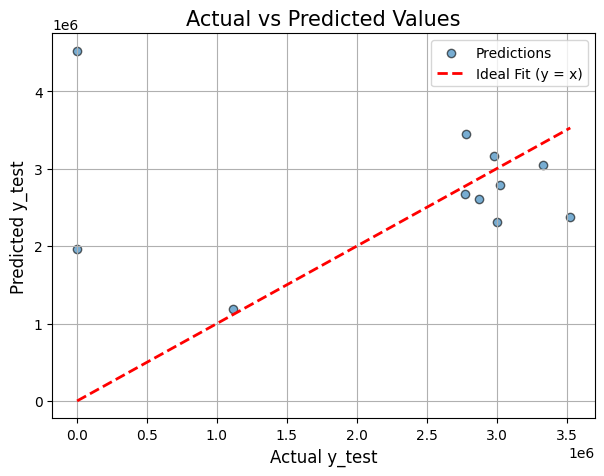


 Calculating Feature Elasticity...

 Plotting Feature Elasticity...


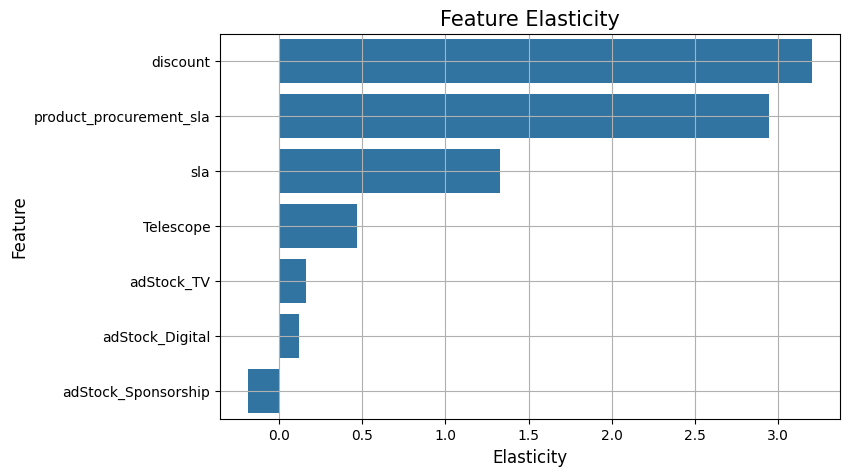

In [25]:
# Run the entire evaluation workflow
r2_test, elasticity_df = run_model_evaluation(X_test, y_test, X_train_rfe_best, y_train, trained_model)